# SBB

In [14]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

## Import Data

In [15]:
df = pd.read_csv('data/zugzahlen.csv')
df.head(10)

,PID,ISB,Strecke_Nummer,Strecke_Bezeichnung,Strecke_Art,BP_Von_Abschnitt,BP_Von_Abschnitt_Bezeichnung,BP_Bis_Abschnitt,BP_Bis_Abschnitt_Bezeichnung,Anzahl_Zuege,...,TU Nummer,Bedienpunkt Cargo,land,Haltestelle,Gde Nummer,gdnr,TU Abkuerzung,Tarifhaltestelle,geopos_von,geopos_bis
0,SBB_GESE_CHY,SBB,1,Genève Aéroport - Lausanne,STRECKE,GESE,Genève-Sécheron,CHY,Chambésy,126307,...,11,None,Switzerland,*,6621,6621,SBB CFF FFS,None,"6.14454714955, 46.2224480511","6.14732717469, 46.2423883571"
1,SBB_GIBU_ROL,SBB,1,Genève Aéroport - Lausanne,STRECKE,GIBU,Gilly-Bursinel,ROL,Rolle,97943,...,11,None,Switzerland,None,5852,5852,SBB CFF FFS,None,"6.30636755445, 46.4450640594","6.3364074853, 46.4627442908"
2,SBB_MIES_TAN,SBB,1,Genève Aéroport - Lausanne,STRECKE,MIES,Mies,TAN,Tannay,126101,...,11,None,Switzerland,*,5723,5723,SBB CFF FFS,None,"6.16956925257, 46.2998837999","6.18111951391, 46.3076442488"
3,SBB_MOR_STJ,SBB,1,Genève Aéroport - Lausanne,STRECKE,MOR,Morges,STJ,Morges-St-Jean,121566,...,11,*,Switzerland,*,5642,5642,SBB CFF FFS,None,"6.49396657295, 46.5110943408","6.5080466068, 46.5181943179"
4,SBB_PER_ALL,SBB,1,Genève Aéroport - Lausanne,STRECKE,PER,Perroy,ALL,Allaman,98005,...,11,None,Switzerland,None,5860,5860,SBB CFF FFS,None,"6.3629973972, 46.4712243911","6.3997071623, 46.4757445942"
5,SBB_PRN_GLA,SBB,1,Genève Aéroport - Lausanne,STRECKE,PRN,Prangins,GLA,Gland,98503,...,11,None,Switzerland,None,5725,5725,SBB CFF FFS,None,"6.24498850107, 46.3960039685","6.26913796108, 46.4199840811"
6,SBB_TUI_GDBE,SBB,1,Genève Aéroport - Lausanne,STRECKE,TUI,Les Tuileries,GDBE,Genthod-Bellevue,126311,...,11,None,Switzerland,*,6606,6606,SBB CFF FFS,None,"6.14732757249, 46.2499580317","6.15395779335, 46.2567477219"
7,SBB_JON_SJ,SBB,2,St-Jean / Furet - Lancy-Bâtie - Chêne-Bourg-Fr...,STRECKE,JON,Jonction (Genève),SJ,St-Jean (bif),25814,...,11,*,Switzerland,None,6621,6621,SBB CFF FFS,None,"6.12084808769, 46.2018478104","6.12771746891, 46.2055677891"
8,SBB_LABA_LAPR,SBB,2,St-Jean / Furet - Lancy-Bâtie - Chêne-Bourg-Fr...,STRECKE,LABA,Lancy-Bâtie (bif),LAPR,Lancy-Pont-Rouge,25795,...,11,None,Switzerland,None,6628,6628,SBB CFF FFS,None,"6.12512743566, 46.1898778174","6.12495526234, 46.1859404067"
9,SBB_RUS_SY,SBB,3,La Plaine Frontière - Genève,STRECKE,RUS,Russin,SY,Satigny,40988,...,11,None,Switzerland,*,6637,6637,SBB CFF FFS,None,"6.01754977864, 46.1877882306","6.03749960767, 46.2142381831"


In [16]:
df['lon_von'] = df.geopos_von.str.split('\,').str[0]
df['lon_von'] = df['lon_von'].map(float)

In [17]:
df['lat_von'] = df.geopos_von.str.split('\,').str[1]
df['lat_von'] = df['lat_von'].map(float)

In [18]:
df['lon_bis'] = df.geopos_bis.str.split('\,').str[0]
df['lon_bis'] = df['lon_bis'].map(float)

In [19]:
df['lat_bis'] = df.geopos_bis.str.split('\,').str[1]
df['lat_bis'] = df['lat_bis'].map(float)

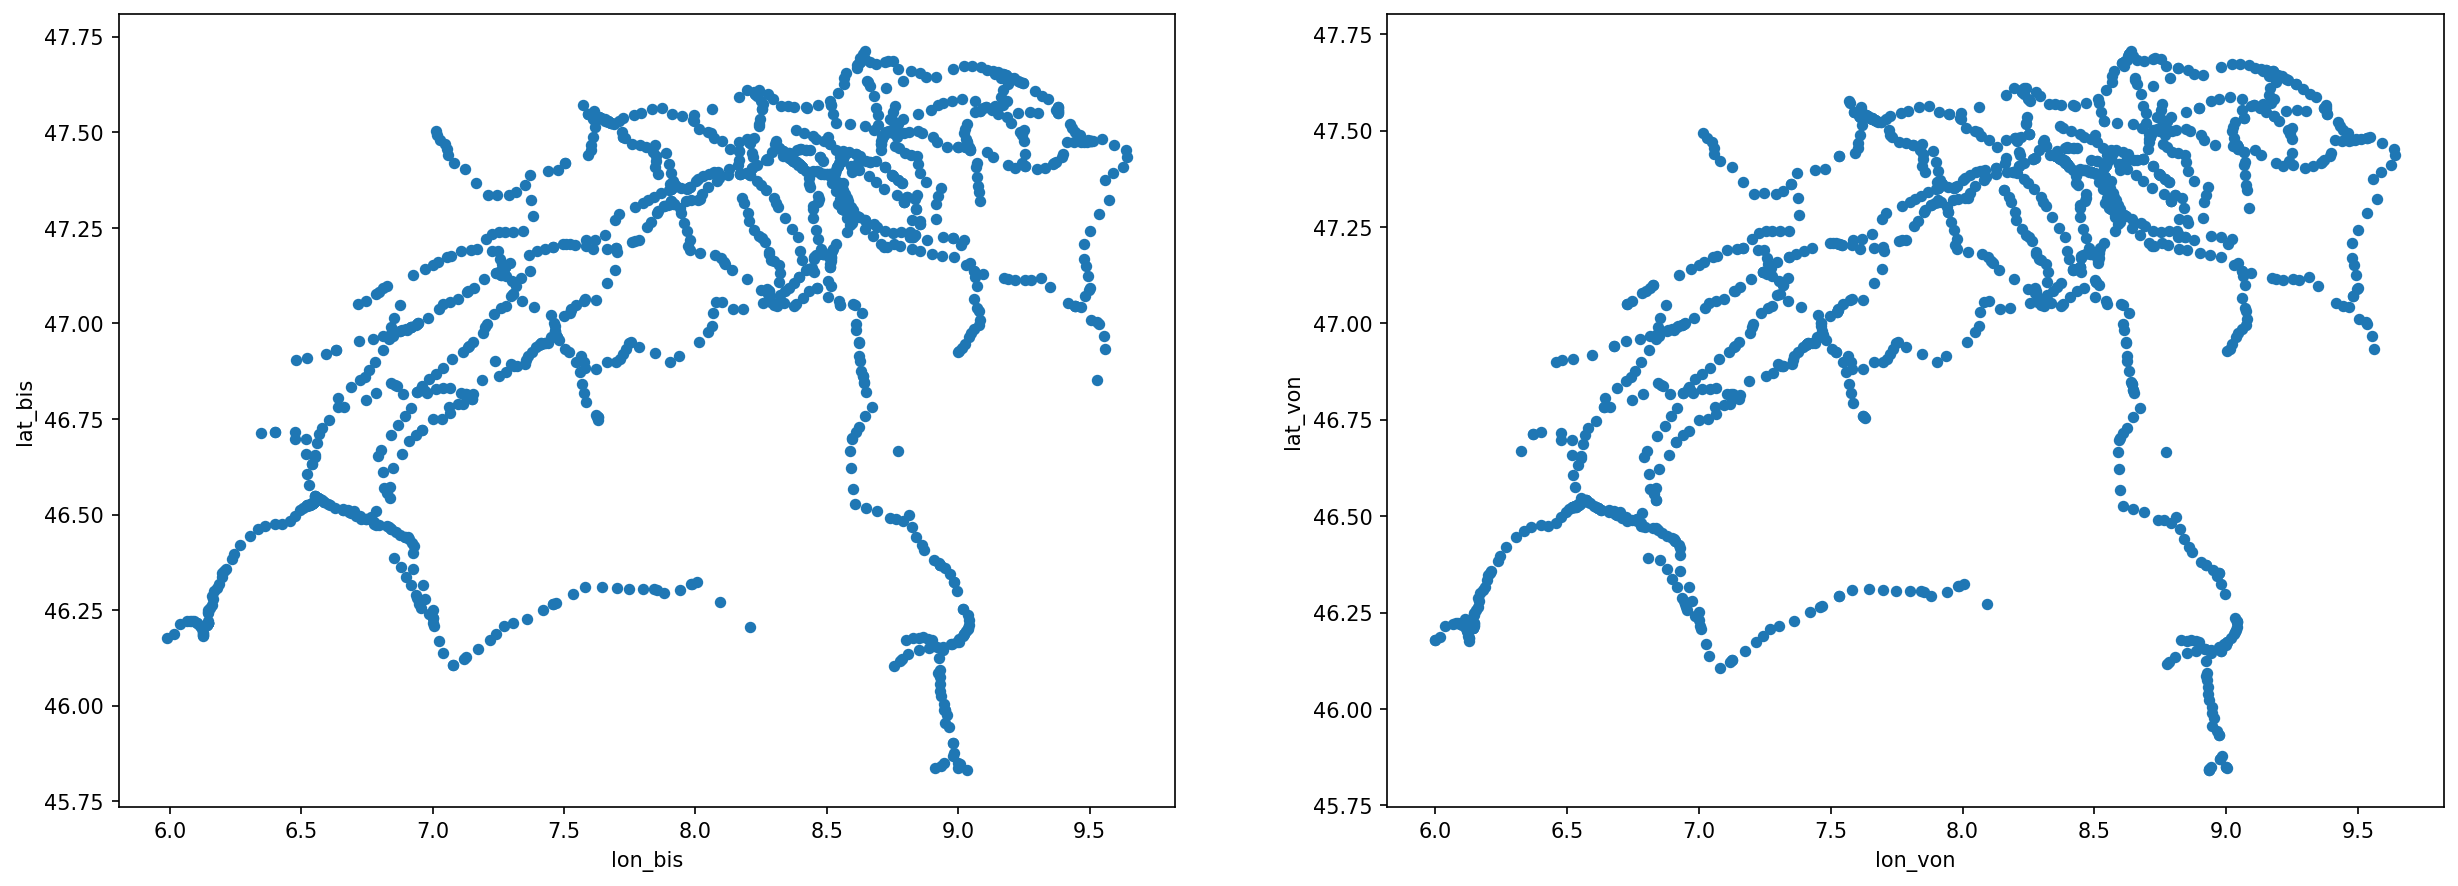

In [137]:
fig, axes = plt.subplots(figsize = (20,7), nrows=1, ncols=2, dpi=150);
df.plot.scatter(ax=axes[1], x='lon_von', y ='lat_von');
df.plot.scatter(ax=axes[0], x='lon_bis', y ='lat_bis');

In [138]:
pos_von = {}
for i in range(0, len(df)):
    pos_von[df.BP_Von_Abschnitt[i]] = (df.lon_von[i], df.lat_von[i])

In [139]:
name_von = {}
for i in range(0, len(df)):
    name_von[df.BP_Von_Abschnitt[i]] = df.BP_Von_Abschnitt_Bezeichnung[i]

In [140]:
pos_bis = {}
for i in range(0, len(df)):
    pos_bis[df.BP_Bis_Abschnitt[i]] = (df.lon_bis[i], df.lat_bis[i])

In [141]:
name_bis = {}
for i in range(0, len(df)):
    name_bis[df.BP_Bis_Abschnitt[i]] = df.BP_Bis_Abschnitt_Bezeichnung[i]

In [142]:
# Magic merge of dictionaries
pos = {**pos_bis, **pos_von}

In [143]:
# Magic merge of dictionaries
name = {**name_bis, **name_von}

In [144]:
df['weight'] = df['Anzahl_Zuege'].map(float)
df['weight'] /= np.max(df['weight'])

## Building the Network

In [145]:
import warnings
warnings.filterwarnings('ignore')

In [146]:
D = nx.from_pandas_edgelist(df, source = 'BP_Von_Abschnitt',
                            target = 'BP_Bis_Abschnitt',
                            edge_attr = 'weight',
                            create_using = nx.DiGraph())

In [147]:
G = nx.Graph(D)

In [148]:
bond = np.array(list(nx.get_edge_attributes(G,'weight').values()))

In [149]:
# Calculate degree centrality,
eigenvector_centrality = nx.eigenvector_centrality(G)

# Set degree centrality metrics on each node,
nx.set_node_attributes(G, eigenvector_centrality, 'ec')

# Set name on each node,
nx.set_node_attributes(G, name, 'name')

# Use eigenvector centrality for visualization.
ec = np.array(list(nx.get_node_attributes(G,'ec').values()))

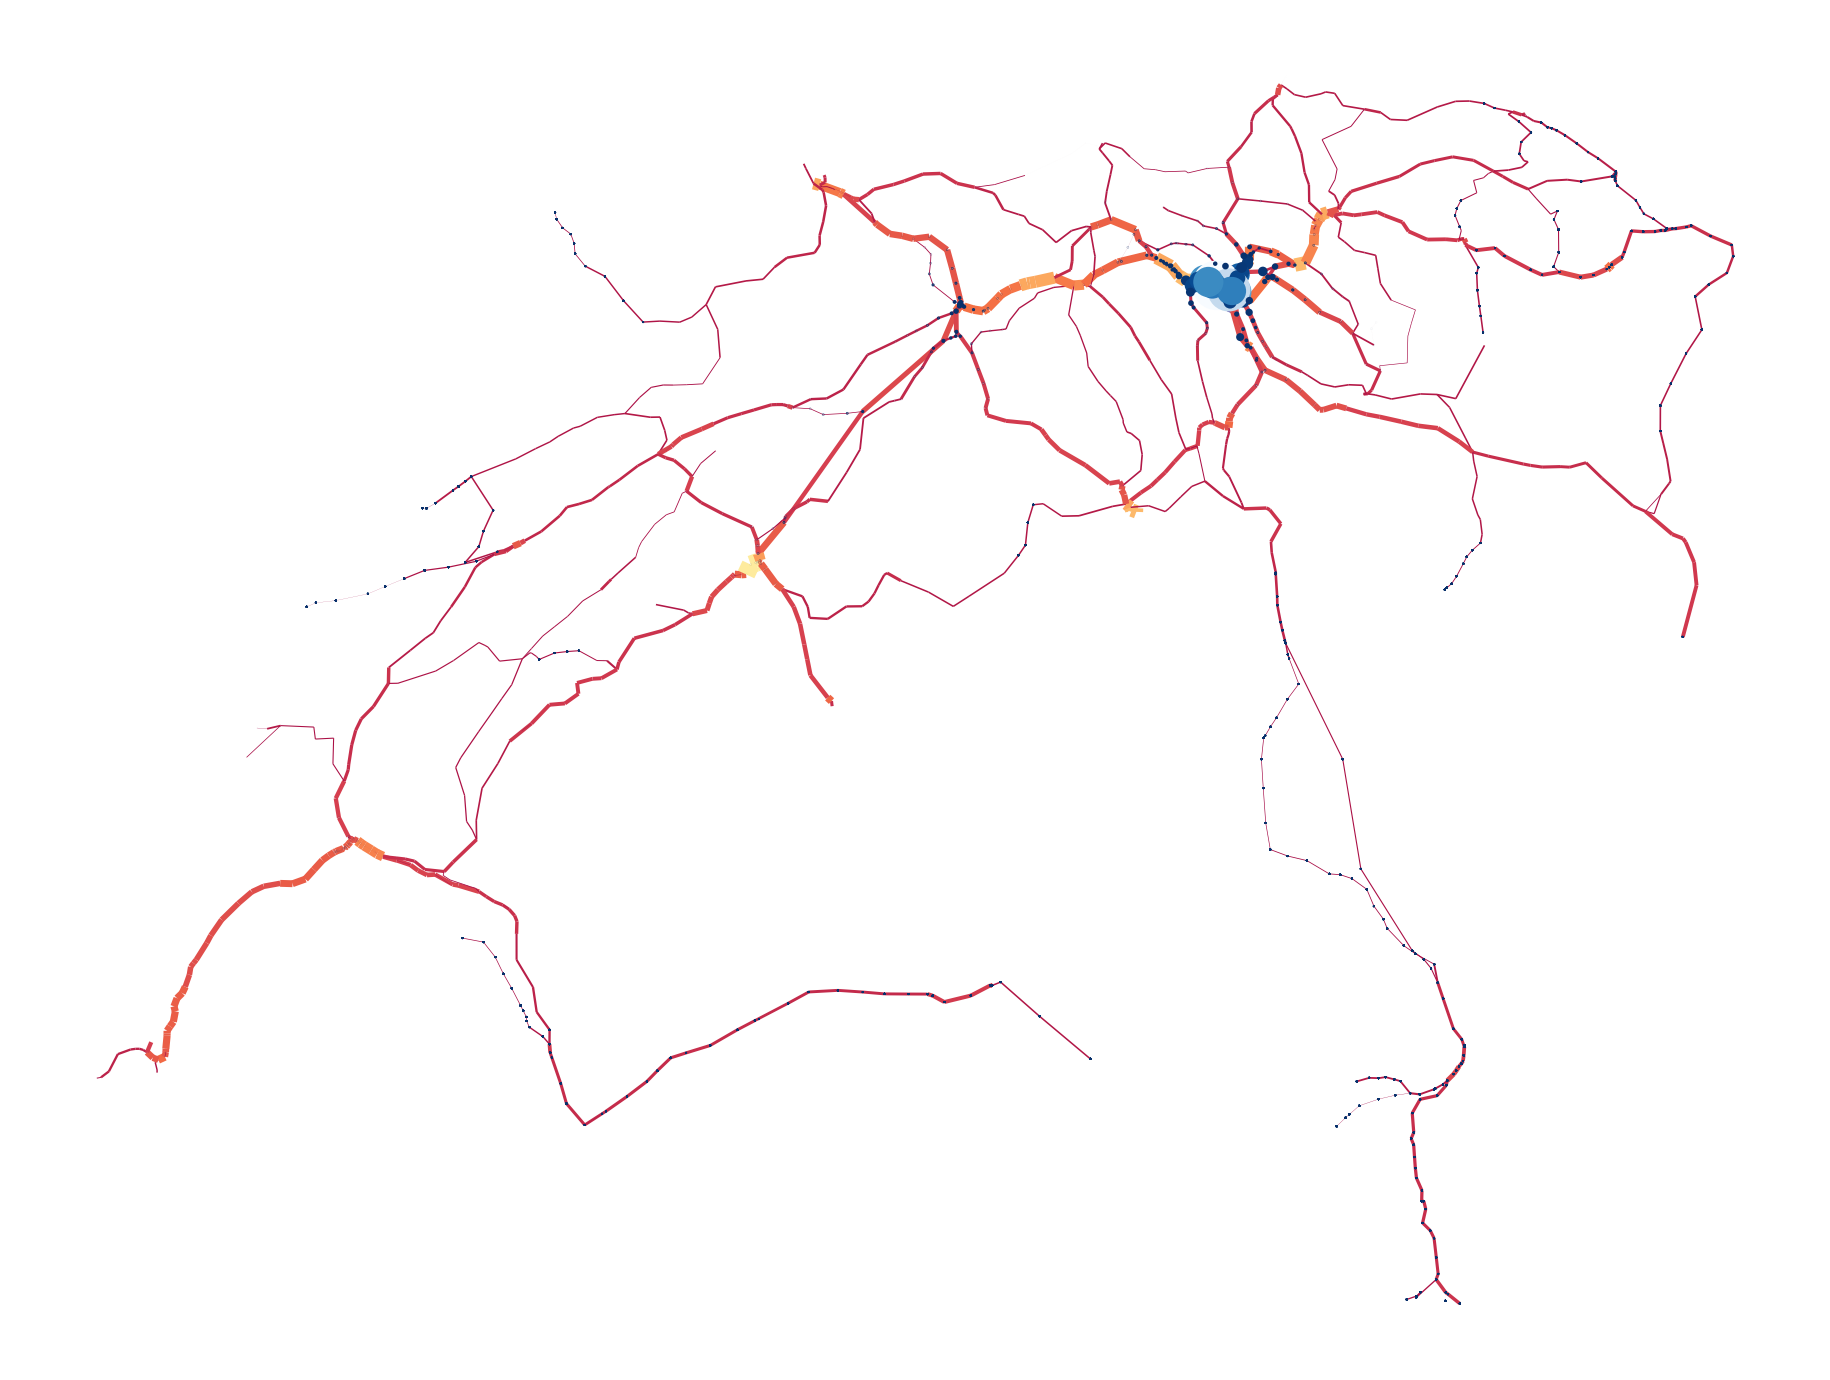

In [150]:
plt.figure(figsize = (12,9), dpi=150)
nx.draw(G, pos=pos, edge_color=bond, node_color=ec, with_labels=False,
        node_size=ec*1000, width=bond*20,
        edge_cmap=plt.cm.Spectral, cmap=plt.cm.Blues_r)
plt.savefig('SBB/map.jpg')

## Networkx to JSON

In [151]:
from networkx.readwrite import json_graph
data = json_graph.node_link_data(G)

### Data links (Graph Edges)

In [152]:
data['links'][0]

{'weight': 0.17134388290115377, 'source': 'GESE', 'target': 'CHY'}

In [153]:
pos[data['links'][0]['source']]

(6.14454714955, 46.2224480511)

In [154]:
pos[data['links'][0]['target']]

(6.14732717469, 46.2423883571)

### Data nodes (Graph Vertices)

In [155]:
data['nodes'][0]

{'ec': 6.0304689797736505e-09, 'name': 'Genève-Sécheron', 'id': 'GESE'}

In [156]:
data['nodes'][0]['id']

'GESE'

In [157]:
pos[data['nodes'][0]['id']]

(6.14454714955, 46.2224480511)

In [158]:
data['nodes'][0]

{'ec': 6.0304689797736505e-09, 'name': 'Genève-Sécheron', 'id': 'GESE'}

### GeoJSON

In [159]:
import json

In [178]:
from shapely.geometry import Point, LineString

In [161]:
from shapely_geojson import dumps, Feature, FeatureCollection

Node features

In [181]:
node_features = []

In [182]:
for d, i in enumerate(data['nodes']):
    feature = Feature(Point(pos[data['nodes'][d]['id']]), properties=data['nodes'][d])
    node_features.append(feature)

In [183]:
feature_collection = FeatureCollection(node_features)

In [194]:
geojson = dumps(feature_collection, indent=2, ensure_ascii=False)
#print(geojson)

Edge features

In [196]:
edge_features = []

In [197]:
for d, i in enumerate(data['links']):
    feature = Feature(LineString([Point(pos[data['links'][d]['source']]),
                                  Point(pos[data['links'][d]['target']])]), properties=data['links'][d])
    edge_features.append(feature)

In [198]:
feature_collection = FeatureCollection(edge_features)

In [208]:
geojson = dumps(feature_collection, indent=2, ensure_ascii=False)
#print(geojson)

## Network dynamics

In [209]:
_pos = nx.spring_layout(G, seed=0)

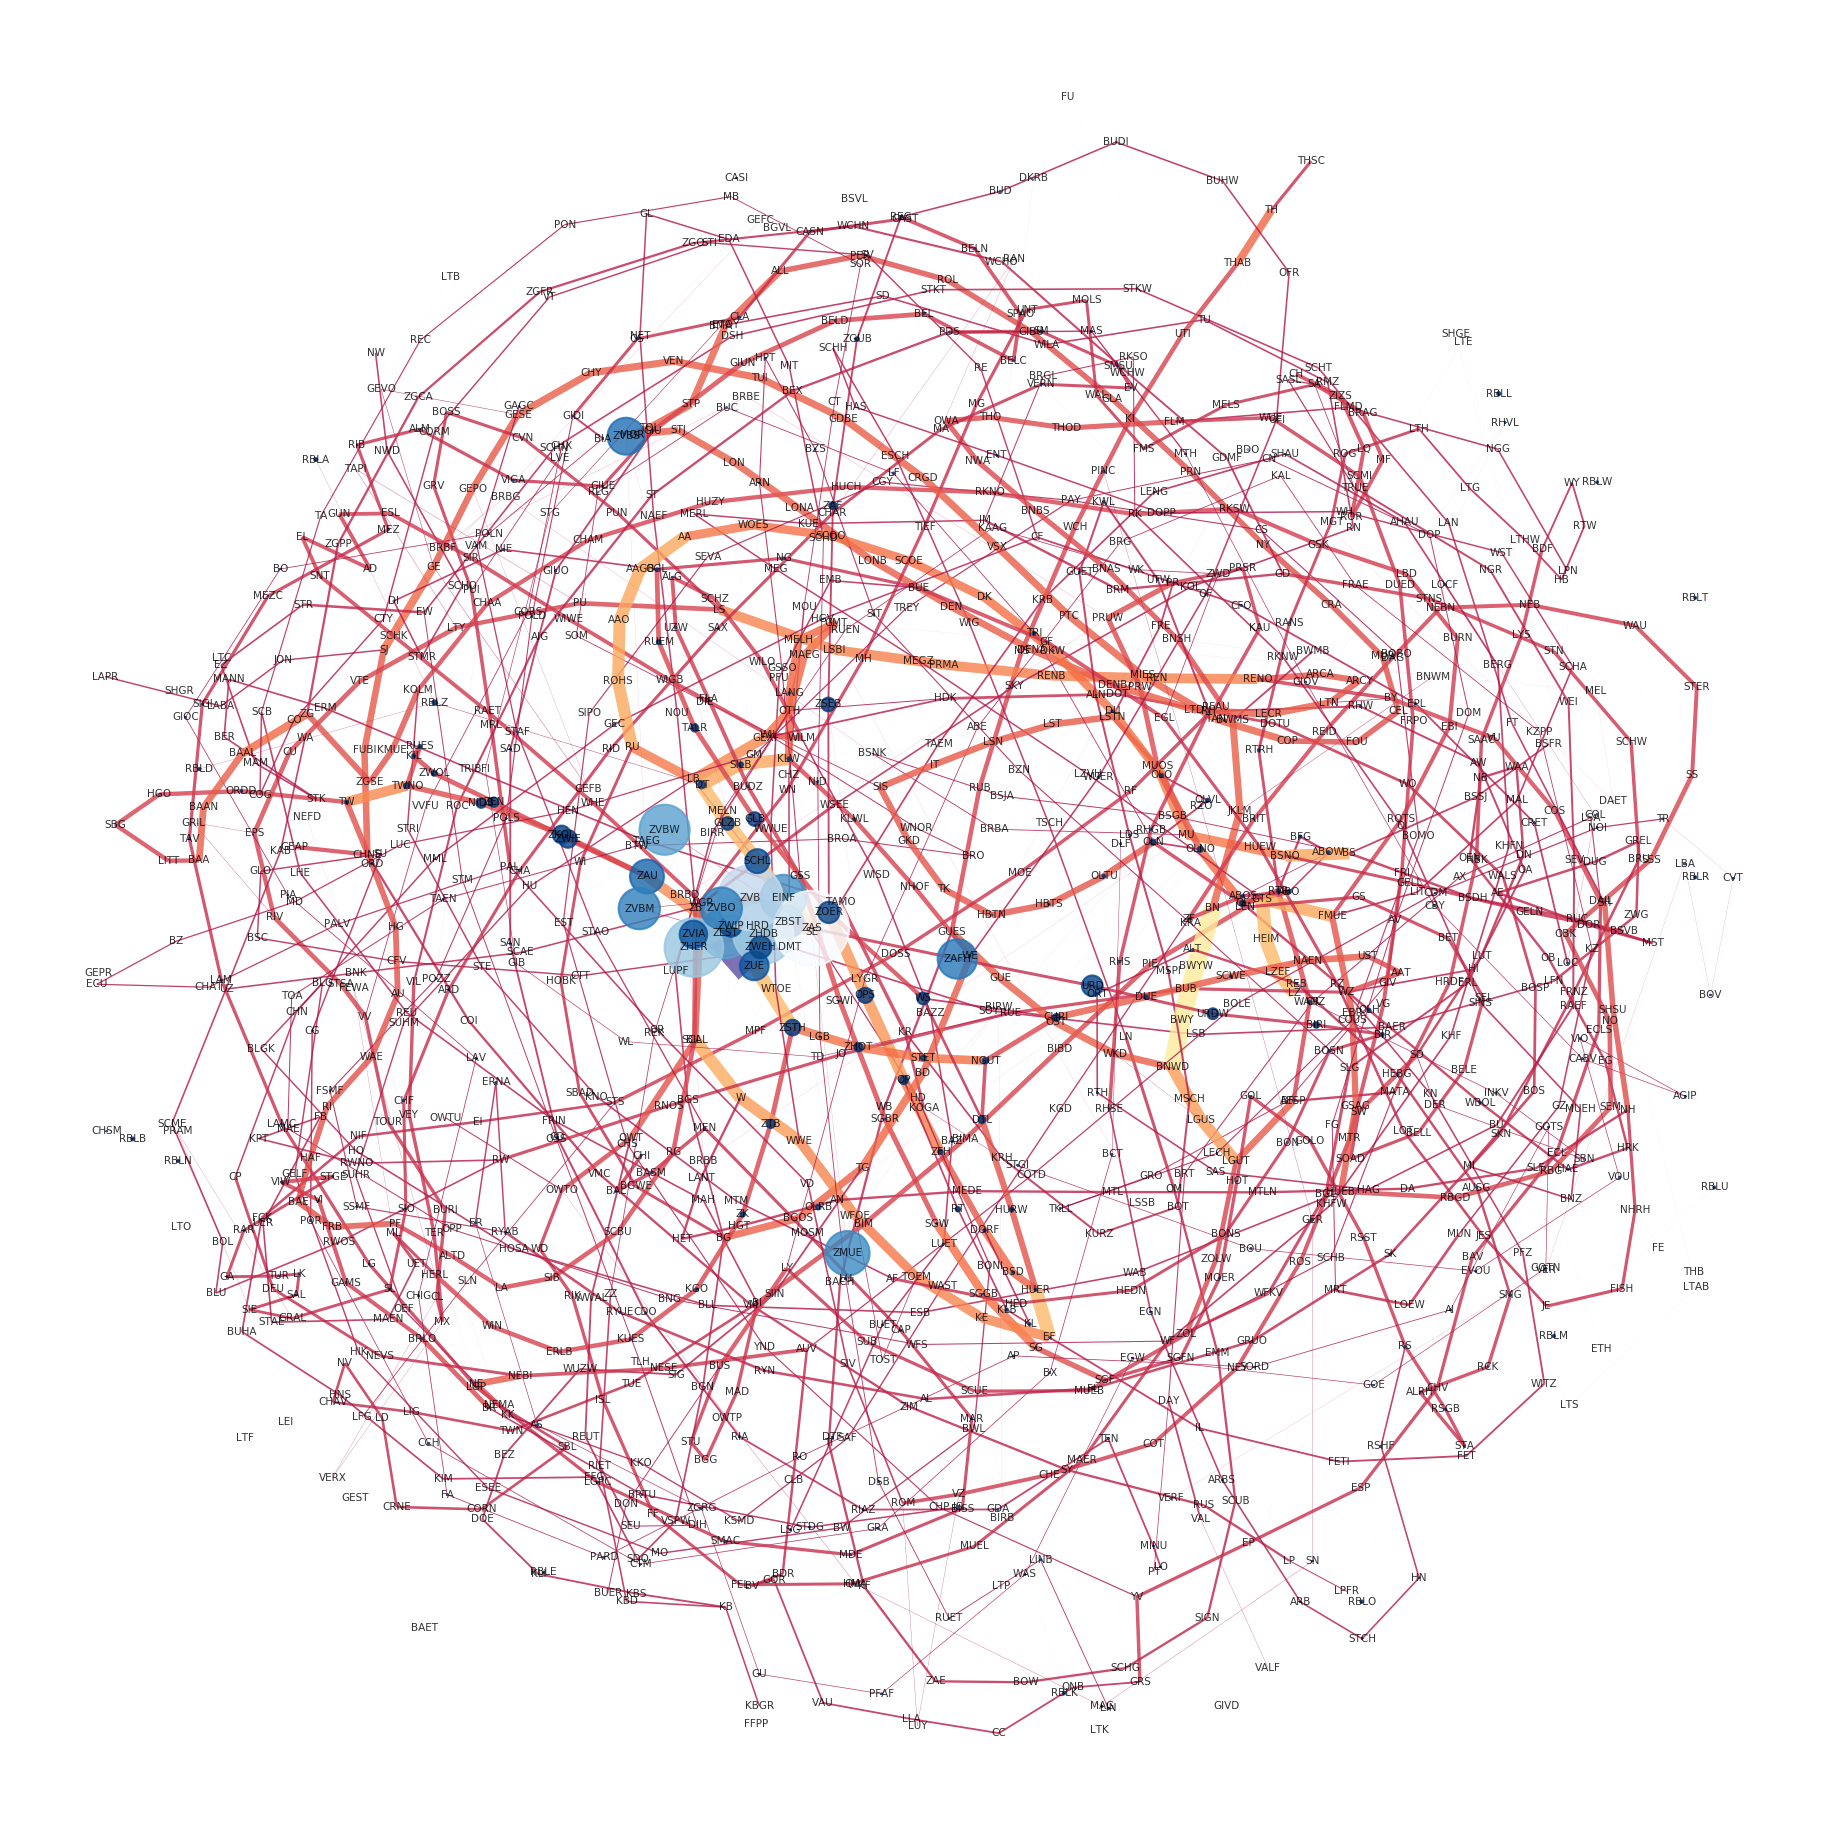

In [210]:
plt.figure(figsize = (12,12), dpi=150)
nx.draw(G, pos=_pos, edge_color=bond, node_color=ec, with_labels=True,
        font_size=5, weight='weight', node_size=ec*2500, width=bond*20,
        edge_cmap=plt.cm.Spectral, cmap=plt.cm.Blues_r, alpha=0.8)
#plt.savefig('SBB/atom.jpg')